# Лабораторная работа 2.9: Параболическое уравнение (уравнение теплопроводности)

## Формулировка задачи

Решается одномерное уравнение теплопроводности:

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

где:
- $u(x,t)$ - температура в точке $x$ в момент времени $t$
- $\alpha = 1.0$ - коэффициент теплопроводности
- $x \in [0, 1]$ - пространственная координата
- $t \geq 0$ - время

**Граничные условия:**
- $u(0, t) = 0$ - левый конец стержня поддерживается при нулевой температуре
- $u(1, t) = \sin(t)$ - правый конец имеет переменную температуру

**Начальное условие:**
- $u(x, 0) = \sin(\pi x)$ - начальное распределение температуры

---

## Аналитическое решение

Решение находится методом разделения переменных. После приведения граничных условий к однородному виду через функцию $s(x,t) = x\sin(t)$, решение имеет вид:

$$u(x, t) = x\sin t + \sum_{k=1}^{\infty} \sin(k\pi x) T_k(t)$$

где функции $T_k(t)$ определяются через интегралы:

- Для $k = 1$:
  $$T_1(t) = e^{-\pi^2 t} - \frac{2}{\pi} \int_0^t \cos \tau \cdot e^{-\pi^2 (t-\tau)} d\tau$$

- Для $k \geq 2$:
  $$T_k(t) = \frac{2(-1)^k}{k\pi} \int_0^t \cos \tau \cdot e^{-(k\pi)^2 (t-\tau)} d\tau$$

В коде используется аппроксимация первыми 20 членами ряда Фурье.

---

## Численный алгоритм (явная схема)

Используется **явная схема конечных разностей**:

1. **Дискретизация:**
   - Пространственная производная: $\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$
   - Временная производная: $\frac{\partial u}{\partial t} \approx \frac{u_i^{n+1} - u_i^n}{\Delta t}$

2. **Разностная схема:**
   $$u_i^{n+1} = u_i^n + r \cdot (u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$
   
   где $r = \alpha \frac{\Delta t}{\Delta x^2}$ - параметр устойчивости

3. **Условие устойчивости (фон Неймана):**
   $$r = \alpha \frac{\Delta t}{\Delta x^2} \leq 0.5$$
   
   В коде используется $r = 0.4$ для обеспечения устойчивости.

4. **Алгоритм:**
   - Инициализация начального условия $u(x,0) = \sin(\pi x)$
   - Для каждого временного слоя $n$:
     - Обновление внутренних точек по разностной схеме
     - Применение граничных условий: $u_0^{n+1} = 0$, $u_{N_x-1}^{n+1} = \sin(t^{n+1})$


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры
L = 1.0
T = 0.5
Nx = 50
dx = L / (Nx - 1)
alpha = 1.0

# Шаг по времени для устойчивости
dt = 0.4 * dx**2 / alpha
Nt = int(T / dt) + 1

x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)


In [35]:
# Аналитическое решение
N_terms = 20  # количество членов ряда для аппроксимации

def T_k_analytical(k, t_val):
    """T_k(t)"""
    if k == 1:
        exp_term = np.exp(-np.pi**2 * t_val)
        integral_term = (np.pi**2 * np.cos(t_val) + np.sin(t_val) - 
                        np.pi**2 * np.exp(-np.pi**2 * t_val)) / (np.pi**4 + 1)
        return exp_term - (2 / np.pi) * integral_term
    else:
        kpi = k * np.pi
        kpi2 = kpi**2
        kpi4 = kpi**4
        exp_term = np.exp(-kpi2 * t_val)
        integral_term = (kpi2 * np.cos(t_val) + np.sin(t_val) - 
                        kpi2 * exp_term) / (kpi4 + 1)
        return (2 * (-1)**k / (k * np.pi)) * integral_term

def u_analytical(x_val, t_val, N_terms=20):
    #u(x,t)
    u_analytical_val = x_val * np.sin(t_val)
    
    for k in range(1, N_terms + 1):
        u_analytical_val += np.sin(k * np.pi * x_val) * T_k_analytical(k, t_val)
    return u_analytical_val

u_analytical_grid = np.zeros((Nt, Nx))
for n in range(Nt):
    for i in range(Nx):
        u_analytical_grid[n, i] = u_analytical(x[i], t[n], N_terms)



In [ ]:
# Численное решение
u = np.zeros((Nt, Nx))

# Начальное условие
u[0, :] = np.sin(np.pi * x)

# Граничные условия для начального момента
u[0, 0] = 0
u[0, -1] = np.sin(t[0])

# Численное решение
r = alpha * dt / (dx**2)
for n in range(Nt - 1):
    # Обновление внутренних точек
    for i in range(1, Nx - 1):
        u[n+1, i] = u[n, i] + r * (u[n, i+1] - 2*u[n, i] + u[n, i-1])
     
    # Граничные условия
    u[n+1, 0] = 0
    u[n+1, -1] = np.sin(t[n+1])

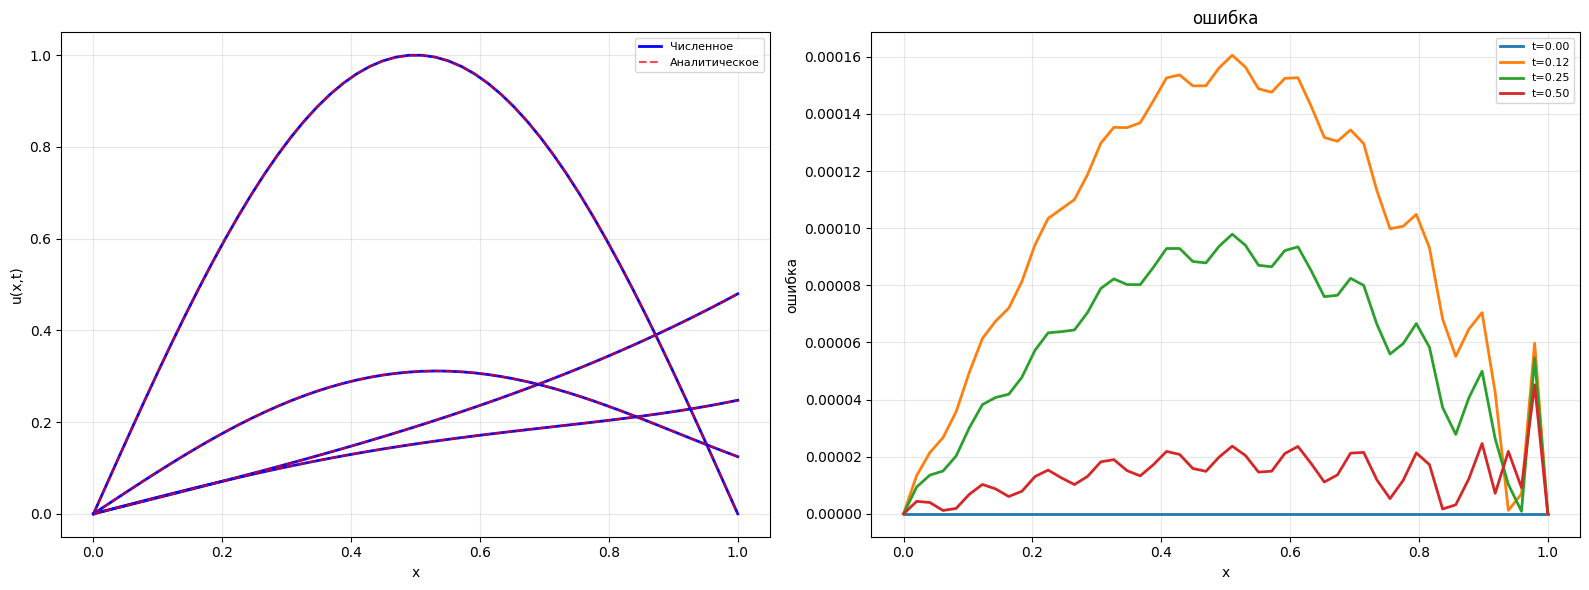

In [37]:
# Сравнение решений
time_indices = [0, Nt//4, Nt//2, Nt-1]
error = np.abs(u - u_analytical_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


for idx in time_indices:
    if idx == time_indices[0]:
        ax1.plot(x, u[idx, :], 'b-', label='Численное', linewidth=2)
        ax1.plot(x, u_analytical_grid[idx, :], 'r--', label='Аналитическое', linewidth=1.5, alpha=0.7)
    else:
        ax1.plot(x, u[idx, :], 'b-', linewidth=2)
        ax1.plot(x, u_analytical_grid[idx, :], 'r--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,t)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

for idx in time_indices:
    ax2.plot(x, error[idx, :], label=f't={t[idx]:.2f}', linewidth=2)
ax2.set_xlabel('x')
ax2.set_ylabel('ошибка')
ax2.set_title('ошибка')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
